### Federated Fine-tuning for ASR
* Centralized: You fine-tune DistilHuBERT for downstream ASR tasks.
* FL: Simulate a federated ASR learning scenario where multiple clients (speakers) fine-tune a shared model on local speech data using FedAvg/FedOpt.

In [1]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
import torch
import copy
from datasets import load_from_disk
from transformers import (
    AutoProcessor,
    AutoModelForCTC,
    TrainingArguments,
    Trainer
)
from typing import List, Dict
from collections import defaultdict
from torch.utils.data import Dataset
import numpy as np
import random
import jiwer
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
dataset = load_from_disk("/scratch/pippalin2/jupyter/GMM-DistilHuBERT/processed_dataset")
dataset = dataset.train_test_split(test_size=0.1)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

Loading dataset from disk:   0%|          | 0/47 [00:00<?, ?it/s]

In [4]:
train_dataset

Dataset({
    features: ['input_values', 'labels'],
    num_rows: 25670
})

#### Simulating FL setting: clients

In [5]:
def split_into_clients_nonuniform(dataset, num_clients, min_frac, max_frac):
    size = len(dataset)

    proportions = np.random.uniform(min_frac, max_frac, size=num_clients)
    proportions = proportions / proportions.sum()
    sizes = (proportions * size).astype(int)

    # Ensure total size matches
    diff = size - sizes.sum()
    sizes[0] += diff

    # Client splits
    indices = np.arange(size)
    np.random.shuffle(indices)

    client_datasets = []
    start = 0
    for s in sizes:
        end = start + s
        client_datasets.append(dataset.select(indices[start:end].tolist()))
        start = end

    return client_datasets
client_datasets = split_into_clients_nonuniform(train_dataset, num_clients=20, min_frac=0.01, max_frac=0.1)

In [6]:
processor = AutoProcessor.from_pretrained("/scratch/pippalin2/jupyter/GMM-DistilHuBERT/processor")
base_model = AutoModelForCTC.from_pretrained("ntu-spml/distilhubert").to("cuda")

Some weights of HubertForCTC were not initialized from the model checkpoint at ntu-spml/distilhubert and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
class DataCollatorCTCWithPadding:
    def __init__(self, processor, padding=True):
        self.processor = processor
        self.padding = padding

    def __call__(self, features: List[Dict]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": f["input_values"]} for f in features]
        label_features = [{"input_ids": f["labels"]} for f in features]

        batch = self.processor.feature_extractor.pad(input_features, padding=self.padding, return_tensors="pt")
        labels_batch = self.processor.tokenizer.pad(label_features, padding=self.padding, return_tensors="pt")
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels
        return batch

data_collator = DataCollatorCTCWithPadding(processor)


In [8]:
model_save_path = "/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/FedAvg_checkpoints"
os.makedirs(model_save_path, exist_ok=True)

In [9]:
def local_finetune(model, dataset, processor, collator, compute_metrics, output_dir):
    training_args = TrainingArguments(
        output_dir=model_save_path,
        per_device_train_batch_size=2,
        eval_strategy="no",
        num_train_epochs=2,
        eval_steps=400,
        logging_steps=10,
        save_steps=500,
        learning_rate=1e-4,
        fp16=True,
        resume_from_checkpoint=False,
        report_to="none"
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
        tokenizer=processor,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )
    train_output = trainer.train()
    metrics = {
    "train_loss": train_output.training_loss,
    "train_steps": trainer.state.global_step,
    }
    return model.state_dict(), metrics

# uniform weight
def fed_avg(state_dicts: List[Dict]):
    avg_dict = copy.deepcopy(state_dicts[0])
    for key in avg_dict:
        for i in range(1, len(state_dicts)):
            avg_dict[key] += state_dicts[i][key]
        avg_dict[key] = avg_dict[key] / len(state_dicts)
    return avg_dict

Since this simulation involves only 20 clients, using uniform weights helps ensure that each client contributes equally to the global model, avoiding dominance by clients with larger local datasets.\
This choice reduces the risk of model bias toward data-rich clients and promotes fairness — especially important in small-scale federated settings where heterogeneity could otherwise overwhelm a few participants.

In [10]:
transform = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemovePunctuation(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
])

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = torch.argmax(torch.tensor(pred_logits), dim=-1)

    # Decode predictions
    pred_str = processor.batch_decode(pred_ids)

    # Decode references
    label_ids = pred.label_ids
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, group_tokens=False)

    # Normalize
    pred_str = [transform(p) for p in pred_str]
    label_str = [transform(l) for l in label_str]

    # Compute metrics
    wer = jiwer.wer(label_str, pred_str)
    cer = jiwer.cer(label_str, pred_str)

    # Sentence Error Rate: fraction of sentences with at least 1 error
    ser = sum(p != l for p, l in zip(pred_str, label_str)) / len(label_str)

    return {
        "wer": wer,
        "cer": cer,
        "ser": ser,
    }


def evaluate_global_model(global_model, eval_dataset):
    eval_args = TrainingArguments(
        output_dir= model_save_path,
        per_device_eval_batch_size=4,
        report_to="none",
        do_train=False,
        do_eval=True,
        dataloader_drop_last=False,
    )

    eval_trainer = Trainer(
        model=global_model,
        args=eval_args,
        tokenizer=processor.tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        eval_dataset=eval_dataset
    )

    results = eval_trainer.evaluate()
    print(f"Eval after round: WER={results['eval_wer']:.4f}, CER={results['eval_cer']:.4f}, SER={results['eval_ser']:.4f}")
    return results

#### FedAvg

In [11]:
global_model = deepcopy(base_model)
round_metrics = []

for round_num in range(10):
    print(f"Round {round_num + 1}")
    selected_clients = random.sample(client_datasets, k=5)
    weights = []
    client_losses = []

    for i, client_data in enumerate(selected_clients):
        print(f"Client {i+1} (data size: {len(client_data)})")
        local_model = copy.deepcopy(global_model)
        state, train_metrics = local_finetune(
            local_model,
            client_data,
            processor,
            data_collator,
            compute_metrics,
            model_save_path, 
        )
        weights.append(state)
        client_losses.append(train_metrics["train_loss"])

    # FedAvg
    avg_weights = fed_avg(weights)
    global_model.load_state_dict(avg_weights)

    # Save the global model
    round_model_dir = os.path.join(model_save_path, f"round{round_num+1}_global_model")
    os.makedirs(round_model_dir, exist_ok=True)
    global_model.save_pretrained(round_model_dir)

    # Evaluate global model and log metrics
    eval_metrics = evaluate_global_model(global_model, eval_dataset)

    round_metrics.append({
        "round": round_num + 1,
        "train_loss": sum(client_losses) / len(client_losses),
        "train_steps": train_metrics["train_steps"],
        "eval_loss": eval_metrics.get("eval_loss"),
        "eval_wer": eval_metrics.get("eval_wer"),
        "eval_cer": eval_metrics.get("eval_cer"),
        "eval_ser": eval_metrics.get("eval_ser"),
    })

Round 1
Client 1 (data size: 2356)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2336.855300
20,1118.408300
30,1095.097600
40,1116.550600
50,1080.965200
60,1097.838200
70,1055.103400
80,1108.191300
90,1142.380600
100,1068.973300


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Client 2 (data size: 2276)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2174.067600
20,1143.092000
30,1103.048200
40,1087.894100
50,1072.468100
60,1048.405000
70,1042.715600
80,1026.762300
90,1120.149900
100,1131.878800


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Client 3 (data size: 1676)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2181.730500
20,1122.076600
30,1075.514000
40,1030.184900
50,1049.924800
60,1063.416000
70,1126.634600
80,1065.287500
90,1107.185700
100,1075.057800


Client 4 (data size: 1170)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2257.661100
20,1116.535300
30,1018.676800
40,1047.238800
50,1085.776400
60,1052.597600
70,1068.381200
80,1013.510800
90,1031.369700
100,1007.415500


Client 5 (data size: 784)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2282.395100
20,1170.734800
30,1101.006500
40,1066.931300
50,1082.823600
60,1134.479900
70,1103.002800
80,1111.436400
90,1012.516000
100,1112.110000


/tmp/ipykernel_661558/1976712192.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=1.0000, SER=1.0000
Round 2
Client 1 (data size: 406)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1019.689100
20,908.403600
30,838.642100
40,783.555700
50,798.382800
60,738.767500
70,751.480300
80,647.800200
90,704.117500
100,680.204600


Client 2 (data size: 1676)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,985.301900
20,905.386300
30,845.783500
40,766.590000
50,733.925300
60,708.731800
70,719.016700
80,648.992800
90,659.947500
100,620.914600


Client 3 (data size: 1170)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1032.157500
20,889.271900
30,789.247000
40,765.210900
50,758.373000
60,697.655000
70,680.152900
80,620.682900
90,623.228500
100,577.916500


Client 4 (data size: 917)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,958.682400
20,944.838400
30,836.283200
40,800.421500
50,750.375800
60,707.866100
70,682.953900
80,667.364400
90,583.503100
100,630.520300


Client 5 (data size: 2276)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1006.498900
20,907.419900
30,855.831500
40,798.982900
50,746.428700
60,688.445300
70,663.680600
80,622.506300
90,650.261800
100,638.775200


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_661558/1976712192.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.8652, CER=0.3637, SER=1.0000
Round 3
Client 1 (data size: 406)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,504.087000
20,483.323800
30,460.003200
40,438.230100
50,467.124800
60,426.243100
70,441.795900
80,388.969400
90,423.944800
100,412.883600


Client 2 (data size: 1676)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,484.238400
20,476.901200
30,462.610800
40,436.356900
50,433.786900
60,441.323900
70,467.713500
80,422.309000
90,439.152600
100,426.459200


Client 3 (data size: 1170)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,519.041300
20,472.059800
30,446.799600
40,451.320200
50,477.238800
60,440.091900
70,444.500700
80,408.685300
90,422.858600
100,389.953800


Client 4 (data size: 917)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,483.235300
20,498.287500
30,460.779800
40,465.820600
50,452.799400
60,437.412900
70,441.562200
80,436.292100
90,392.581800
100,430.137600


Client 5 (data size: 2276)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,498.444200
20,479.919200
30,480.591500
40,467.645800
50,453.189500
60,428.989600
70,430.267100
80,413.474600
90,441.445000
100,438.378000


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_661558/1976712192.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.7712, CER=0.2724, SER=1.0000
Round 4
Client 1 (data size: 406)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,377.563600
20,375.384100
30,358.571400
40,347.120500
50,370.030300
60,333.725600
70,344.289500
80,307.668200
90,334.181000
100,326.197300


Client 2 (data size: 1676)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,361.647900
20,369.318800
30,364.617600
40,343.777200
50,345.531500
60,359.027200
70,385.030900
80,341.604400
90,359.170800
100,354.411600


Client 3 (data size: 1170)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,388.520200
20,364.681800
30,351.300700
40,358.706800
50,386.945900
60,358.481100
70,364.288400
80,333.752400
90,351.129100
100,320.065200


Client 4 (data size: 917)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,364.404200
20,385.499400
30,360.781600
40,365.706700
50,360.314200
60,350.133200
70,360.680900
80,355.871100
90,322.066700
100,356.436100


Client 5 (data size: 2276)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,374.106900
20,372.741000
30,373.068600
40,367.402700
50,362.675800
60,343.925300
70,351.459700
80,341.344000
90,364.103600
100,364.923900


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_661558/1976712192.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.7052, CER=0.2390, SER=1.0000
Round 5
Client 1 (data size: 406)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,317.029200
20,324.496700
30,312.173400
40,303.169700
50,323.118400
60,286.815200
70,293.682400
80,265.610900
90,290.079800
100,282.347100


Client 2 (data size: 1676)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,303.764200
20,318.121600
30,316.470500
40,297.971300
50,301.612600
60,314.555300
70,338.894200
80,297.511600
90,315.563400
100,312.278300


Client 3 (data size: 1170)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,325.737400
20,313.744500
30,302.256600
40,313.301400
50,339.590600
60,315.193600
70,321.313300
80,292.573500
90,312.042100
100,281.701500


Client 4 (data size: 917)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,306.944900
20,331.202300
30,312.553700
40,317.149100
50,313.596700
60,305.450100
70,318.067000
80,313.471400
90,283.165100
100,316.185300


Client 5 (data size: 2276)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,315.229700
20,320.643200
30,322.500200
40,318.725000
50,315.665000
60,298.899200
70,307.509900
80,300.377100
90,319.724500
100,323.281400


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_661558/1976712192.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.6646, CER=0.2204, SER=1.0000
Round 6
Client 1 (data size: 406)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,276.389200
20,290.375100
30,282.153200
40,274.803100
50,293.003000
60,255.819200
70,260.984700
80,237.942700
90,261.932900
100,253.640900


Client 2 (data size: 1676)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,264.095800
20,284.581100
30,284.173400
40,267.332400
50,271.607800
60,284.414000
70,307.305900
80,268.419200
90,285.707500
100,282.273400


Client 3 (data size: 1170)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,284.881300
20,280.534400
30,269.312500
40,283.145600
50,308.305400
60,285.140300
70,291.790900
80,264.140100
90,284.202400
100,255.544200


Client 4 (data size: 917)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,268.676700
20,295.913600
30,279.404000
40,285.855600
50,282.001500
60,276.312000
70,289.618300
80,284.711400
90,257.196600
100,288.832200


Client 5 (data size: 2276)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,277.056500
20,286.564800
30,290.267700
40,287.265000
50,284.899700
60,268.387000
70,276.571300
80,272.536800
90,289.642100
100,294.767900


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_661558/1976712192.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.6338, CER=0.2076, SER=0.9996
Round 7
Client 1 (data size: 406)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,244.869600
20,264.597600
30,259.443100
40,254.639300
50,270.830900
60,232.891000
70,237.092200
80,217.132400
90,240.538400
100,232.468500


Client 2 (data size: 1676)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,232.960000
20,259.502000
30,259.910100
40,243.888800
50,248.514200
60,261.525300
70,283.694300
80,246.229200
90,263.170500
100,259.951400


Client 3 (data size: 1170)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,254.175000
20,255.746700
30,245.067700
40,259.845000
50,283.756900
60,261.840800
70,269.053300
80,241.888800
90,262.854900
100,235.623100


Client 4 (data size: 917)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,239.384300
20,269.306800
30,254.708100
40,262.261200
50,257.664100
60,254.336500
70,267.395500
80,263.002000
90,237.602700
100,267.603300


Client 5 (data size: 2276)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,247.484400
20,260.717300
30,265.409700
40,263.691400
50,261.368300
60,244.831800
70,252.296100
80,251.195800
90,265.993400
100,272.085200


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_661558/1976712192.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.6113, CER=0.1977, SER=0.9996
Round 8
Client 1 (data size: 406)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,218.387000
20,243.119900
30,240.797900
40,238.354900
50,252.691200
60,214.707700
70,217.595100
80,200.190000
90,222.406700
100,215.772600


Client 2 (data size: 1676)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,206.996800
20,238.923100
30,240.667700
40,225.022700
50,229.856100
60,242.856300
70,263.809300
80,227.336200
90,244.704300
100,241.623300


Client 3 (data size: 1170)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,228.085200
20,234.373900
30,224.416300
40,240.661400
50,261.897400
60,243.398000
70,250.387500
80,223.244800
90,245.256200
100,219.404400


Client 4 (data size: 917)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,214.500700
20,247.175000
30,235.058300
40,243.574600
50,238.034000
60,236.776700
70,249.071800
80,245.193200
90,221.753200
100,250.271000


Client 5 (data size: 2276)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,222.761800
20,239.419000
30,244.876100
40,244.324500
50,241.620800
60,225.272500
70,232.508800
80,233.538600
90,247.300700
100,252.642700


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_661558/1976712192.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.5941, CER=0.1907, SER=0.9996
Round 9
Client 1 (data size: 406)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,195.774100
20,224.694600
30,225.207500
40,225.052300
50,238.154200
60,199.762700
70,201.542100
80,186.721800
90,208.343600
100,202.820200


Client 2 (data size: 1676)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,184.644900
20,220.779000
30,224.250900
40,208.423600
50,214.163900
60,226.480300
70,246.510500
80,211.030200
90,229.060900
100,225.892900


Client 3 (data size: 1170)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,205.082300
20,216.904900
30,206.918200
40,224.036400
50,243.110000
60,228.145500
70,234.769300
80,207.831700
90,230.849000
100,205.742800


Client 4 (data size: 917)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,193.295600
20,228.391900
30,218.570100
40,228.069500
50,221.775500
60,222.078700
70,233.472800
80,230.297300
90,208.356000
100,235.878100


Client 5 (data size: 2276)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,201.307000
20,220.586700
30,227.284100
40,227.173900
50,224.775500
60,208.335300
70,215.468500
80,218.375300
90,231.850000
100,235.410400


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_661558/1976712192.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.5790, CER=0.1849, SER=0.9996
Round 10
Client 1 (data size: 406)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,175.583800
20,208.505200
30,212.085900
40,213.110600
50,225.923900
60,186.669900
70,188.789500
80,175.891500
90,197.077400
100,192.155200


Client 2 (data size: 1676)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,164.501400
20,204.354600
30,209.132600
40,193.508200
50,200.015700
60,211.984400
70,231.188700
80,197.070700
90,215.102900
100,211.832400


Client 3 (data size: 1170)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,185.154600
20,202.478200
30,191.752200
40,209.540900
50,226.565300
60,214.318200
70,221.149400
80,194.314600
90,218.390000
100,193.789000


Client 4 (data size: 917)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,173.901300
20,211.927000
30,203.858500
40,214.701800
50,207.922700
60,209.301000
70,220.225500
80,217.102600
90,196.673900
100,223.707800


Client 5 (data size: 2276)


/tmp/ipykernel_661558/1486125750.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,182.266400
20,203.630400
30,212.142900
40,212.085900
50,210.050700
60,193.495700
70,200.593300
80,204.592000
90,218.073800
100,220.158300


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_661558/1976712192.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.5669, CER=0.1803, SER=0.9996


In [12]:
# Save final model and processor
final_model_dir = os.path.join(model_save_path, "fedavg_distilhubert_asr")
global_model.save_pretrained(final_model_dir)
processor.save_pretrained(final_model_dir)

[]

In [13]:
# Save metrics
metrics_df = pd.DataFrame(round_metrics)
metrics_df.to_csv(os.path.join(model_save_path, "FedAvg_round_metrics.csv"), index=False)

#### Reload & plot:

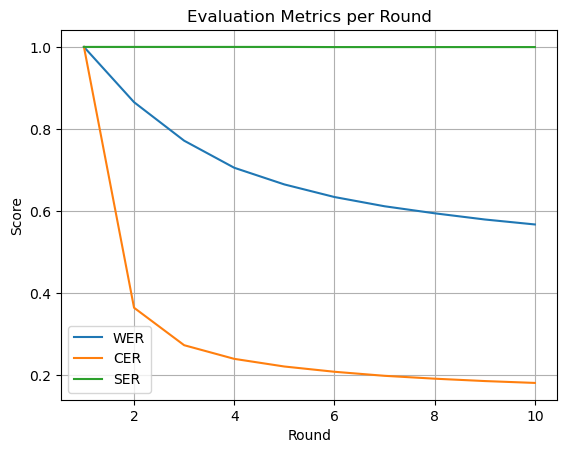

In [16]:
df = pd.read_csv("/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/FedAvg_checkpoints/FedAvg_round_metrics.csv")
plt.plot(df["round"], df["eval_wer"], label="WER")
plt.plot(df["round"], df["eval_cer"], label="CER")
plt.plot(df["round"], df["eval_ser"], label="SER")
plt.xlabel("Round")
plt.ylabel("Score")
plt.title("Evaluation Metrics per Round")
plt.legend()
plt.grid(True)
plt.show()

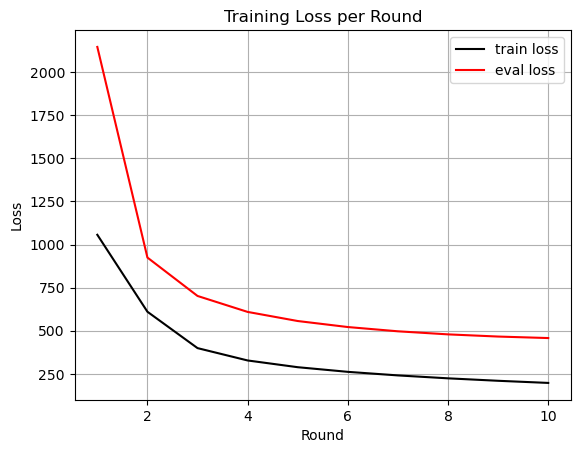

In [21]:
plt.plot(df["round"], df["train_loss"], color='black', label="train loss")
plt.plot(df["round"], df["eval_loss"], color='red', label="eval loss")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("Training Loss per Round")
plt.legend()
plt.grid(True)
plt.show()